In [1]:
import sys
sys.path.append('..')
from jaewook_header import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
images=np.load('../../input/data1-L-images.npy')
masks=np.load('../../input/data1-L-masks.npy')

IMG_HEIGHT,IMG_WIDTH=images.shape[1:3]
BATCH_SIZE=16

In [3]:
from sklearn.model_selection import train_test_split
images_train, images_val, masks_train, masks_val =\
train_test_split(images,masks,test_size=.1,random_state=seed)

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


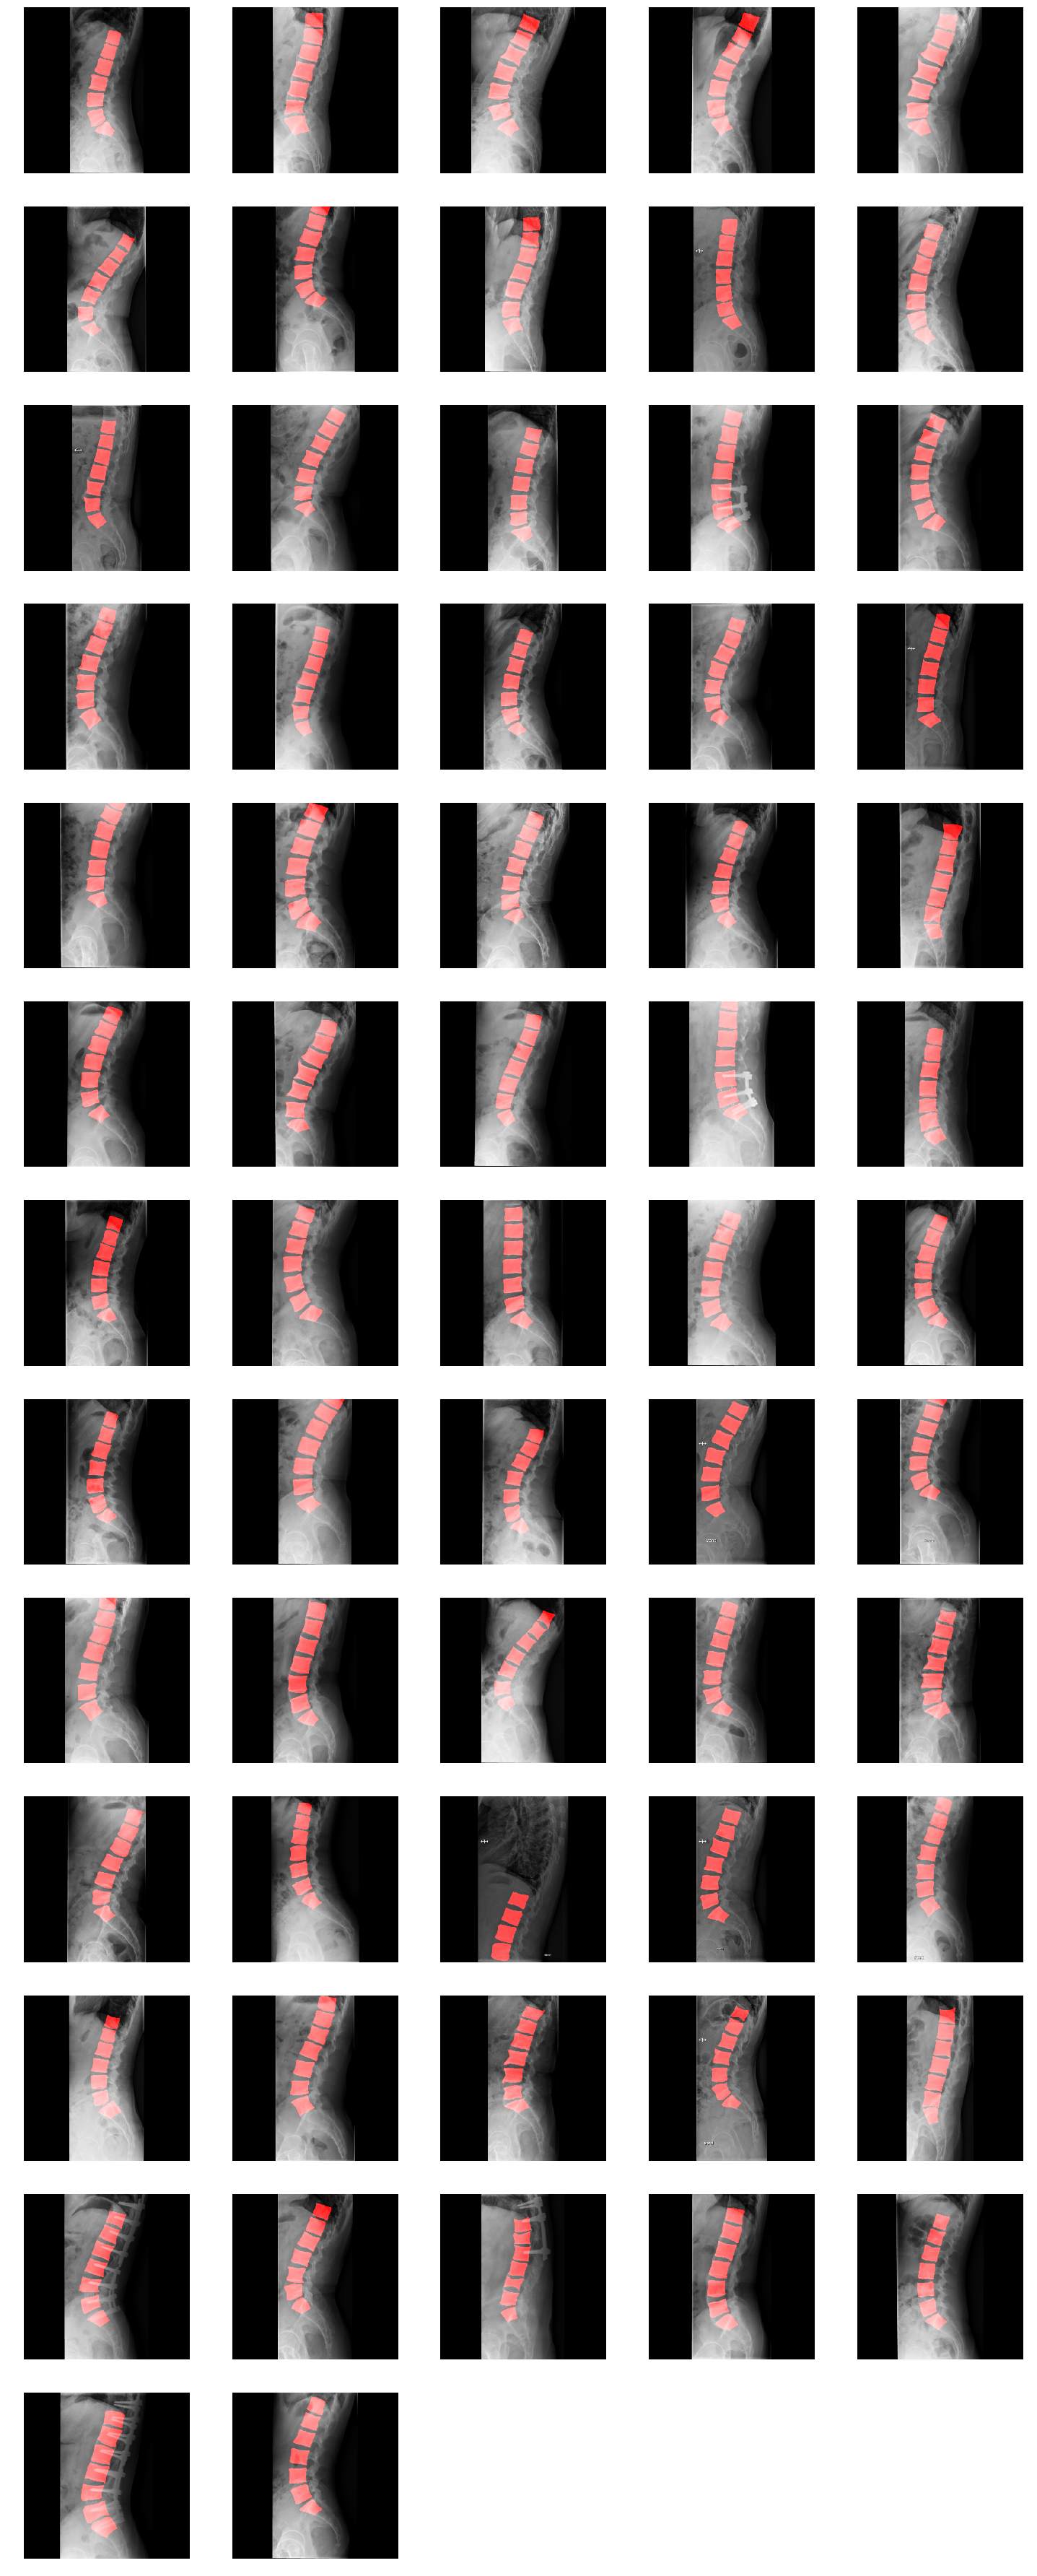

In [4]:
imshow2(overlay(images_train,masks_train))

# Augmentation

In [5]:
data_gen_args=dict(rotation_range=45,
                   width_shift_range=.2,
                   height_shift_range=.2,
                   shear_range=.7,
                   zoom_range=[.9,2.2],
                   horizontal_flip=True,
                   fill_mode='constant')

# train

images_train_datagen=ImageDataGenerator(**data_gen_args)
masks_train_datagen=ImageDataGenerator(**data_gen_args)

images_train_generator=images_train_datagen.flow(images_train,
                                                 batch_size=BATCH_SIZE,
                                                 seed=seed)
masks_train_generator=masks_train_datagen.flow(masks_train,
                                               batch_size=BATCH_SIZE,
                                               seed=seed)

train_generator=zip(images_train_generator,masks_train_generator)

# validation

images_val_datagen=ImageDataGenerator()
masks_val_datagen=ImageDataGenerator()

images_val_generator=images_val_datagen.flow(images_val,seed=seed)
masks_val_generator=masks_val_datagen.flow(masks_val,seed=seed)

val_generator=zip(images_val_generator,masks_val_generator)

# Sanity Check

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


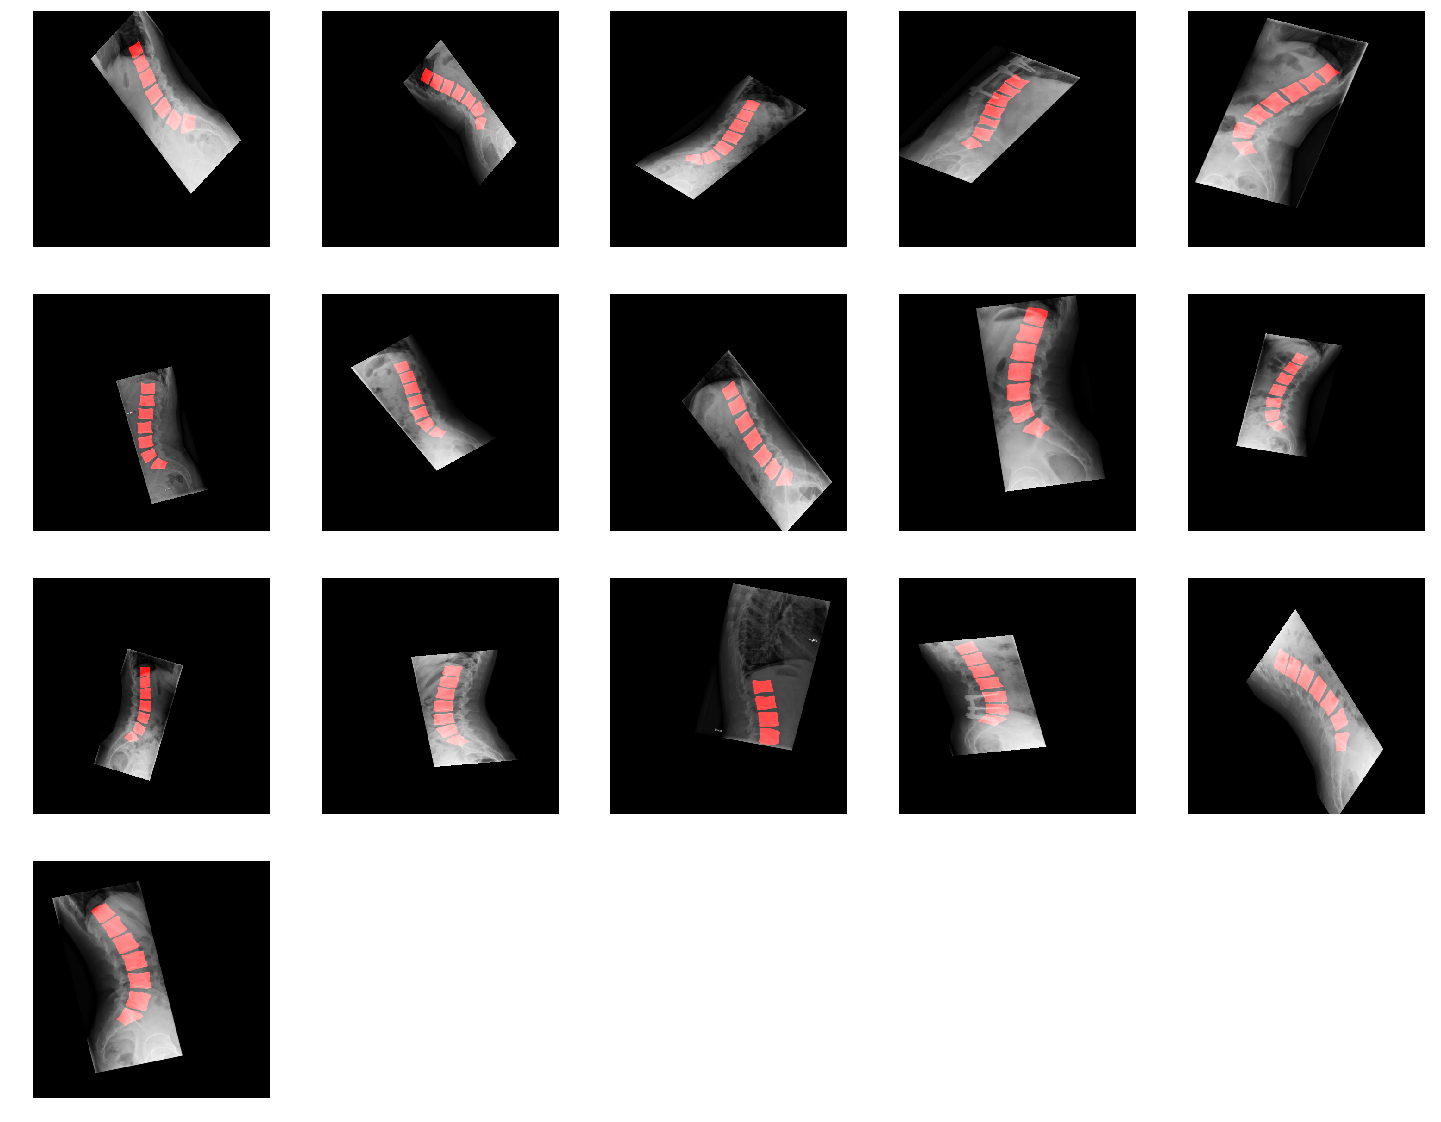

In [6]:
images_preview,masks_preview=next(train_generator)

imshow2(overlay(images_preview,masks_preview))

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


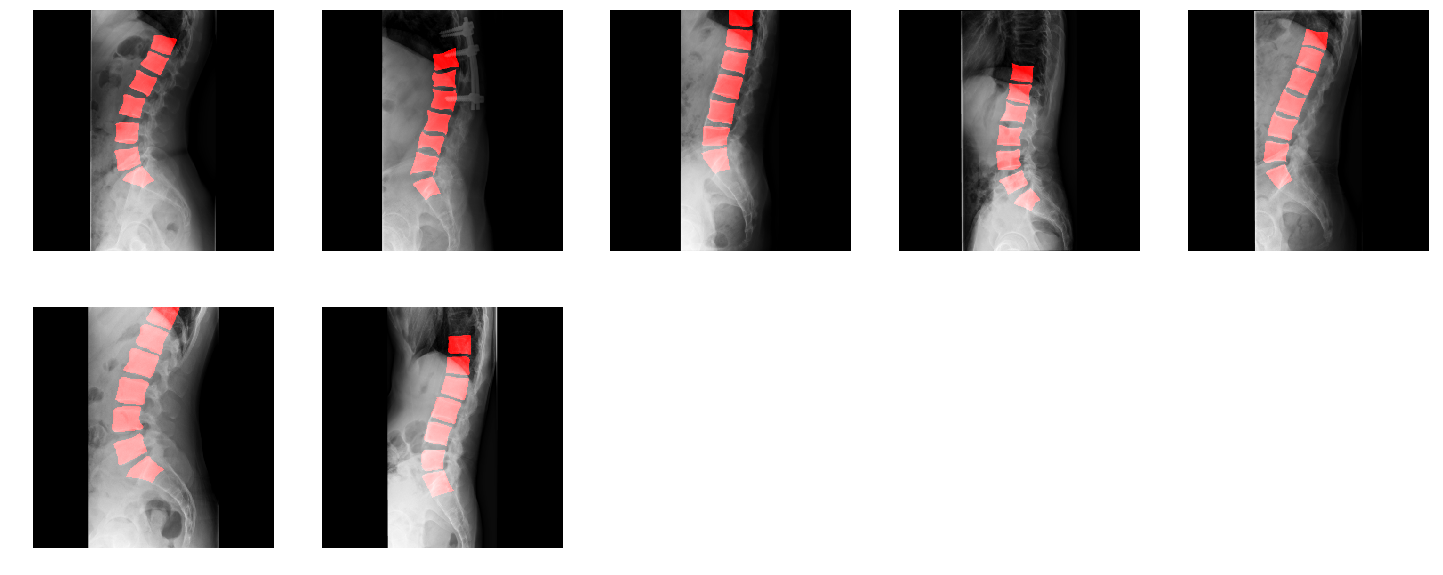

In [7]:
images_preview,masks_preview=next(val_generator)
imshow2(overlay(images_preview,masks_preview))

In [8]:
# 남의 코드
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Model

## Second Trial

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 512, 512, 1)  5158353     lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
__________

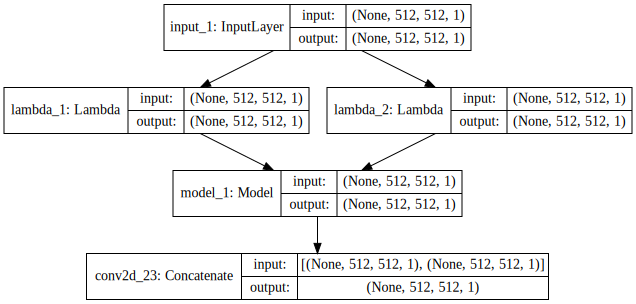

In [9]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
# s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = BatchNormalization() (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization() (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization() (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization() (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c4m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c4m = BatchNormalization() (c4m)
c4m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4m)
p4m = MaxPooling2D(pool_size=(2, 2)) (c4m)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4m)
c5 = BatchNormalization() (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6m = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
u6m = concatenate([u6m, c4m])
c6m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6m)
c6m = BatchNormalization() (c6m)
c6m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6m)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6m)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization() (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization() (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization() (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization() (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model=multi_gpu_model(model,gpus=2)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [10]:
checkpointer = ModelCheckpoint('1130-unet-2nd.h5',
                               monitor='val_mean_iou',
                               mode='max',
                               verbose=1,
                               save_best_only=True)

results=model.fit_generator(train_generator,
                            validation_data=val_generator,
                            validation_steps=1,
                            steps_per_epoch=100,
                            epochs=100,
                            callbacks=[checkpointer])

Epoch 1/100
100/100 [==============================] - 49s 495ms/step - loss: 0.1162 - mean_iou: 0.4827 - val_loss: 0.2007 - val_mean_iou: 0.5091

Epoch 00001: val_mean_iou improved from -inf to 0.50911, saving model to 1130-unet-2nd.h5
Epoch 2/100
100/100 [==============================] - 41s 409ms/step - loss: 0.0435 - mean_iou: 0.5327 - val_loss: 0.1021 - val_mean_iou: 0.5535

Epoch 00002: val_mean_iou improved from 0.50911 to 0.55353, saving model to 1130-unet-2nd.h5
Epoch 3/100
100/100 [==============================] - 41s 414ms/step - loss: 0.0355 - mean_iou: 0.5741 - val_loss: 0.1863 - val_mean_iou: 0.5952

Epoch 00003: val_mean_iou improved from 0.55353 to 0.59519, saving model to 1130-unet-2nd.h5
Epoch 4/100
100/100 [==============================] - 41s 411ms/step - loss: 0.0298 - mean_iou: 0.6122 - val_loss: 0.1227 - val_mean_iou: 0.6299

Epoch 00004: val_mean_iou improved from 0.59519 to 0.62991, saving model to 1130-unet-2nd.h5
Epoch 5/100
100/100 [======================

100/100 [==============================] - 42s 417ms/step - loss: 0.0076 - mean_iou: 0.8716 - val_loss: 0.0397 - val_mean_iou: 0.8724

Epoch 00035: val_mean_iou improved from 0.87068 to 0.87243, saving model to 1130-unet-2nd.h5
Epoch 36/100
100/100 [==============================] - 42s 417ms/step - loss: 0.0070 - mean_iou: 0.8733 - val_loss: 0.0414 - val_mean_iou: 0.8742

Epoch 00036: val_mean_iou improved from 0.87243 to 0.87425, saving model to 1130-unet-2nd.h5
Epoch 37/100
100/100 [==============================] - 42s 418ms/step - loss: 0.0069 - mean_iou: 0.8751 - val_loss: 0.0475 - val_mean_iou: 0.8760

Epoch 00037: val_mean_iou improved from 0.87425 to 0.87598, saving model to 1130-unet-2nd.h5
Epoch 38/100
100/100 [==============================] - 42s 415ms/step - loss: 0.0067 - mean_iou: 0.8768 - val_loss: 0.0345 - val_mean_iou: 0.8776

Epoch 00038: val_mean_iou improved from 0.87598 to 0.87764, saving model to 1130-unet-2nd.h5
Epoch 39/100
100/100 [===========================

100/100 [==============================] - 42s 419ms/step - loss: 0.0056 - mean_iou: 0.9072 - val_loss: 0.0563 - val_mean_iou: 0.9075

Epoch 00069: val_mean_iou improved from 0.90683 to 0.90747, saving model to 1130-unet-2nd.h5
Epoch 70/100
100/100 [==============================] - 42s 422ms/step - loss: 0.0056 - mean_iou: 0.9078 - val_loss: 0.0470 - val_mean_iou: 0.9081

Epoch 00070: val_mean_iou improved from 0.90747 to 0.90806, saving model to 1130-unet-2nd.h5
Epoch 71/100
100/100 [==============================] - 42s 421ms/step - loss: 0.0056 - mean_iou: 0.9084 - val_loss: 0.0488 - val_mean_iou: 0.9087

Epoch 00071: val_mean_iou improved from 0.90806 to 0.90866, saving model to 1130-unet-2nd.h5
Epoch 72/100
100/100 [==============================] - 42s 420ms/step - loss: 0.0053 - mean_iou: 0.9090 - val_loss: 0.0503 - val_mean_iou: 0.9093

Epoch 00072: val_mean_iou improved from 0.90866 to 0.90927, saving model to 1130-unet-2nd.h5
Epoch 73/100
100/100 [===========================

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


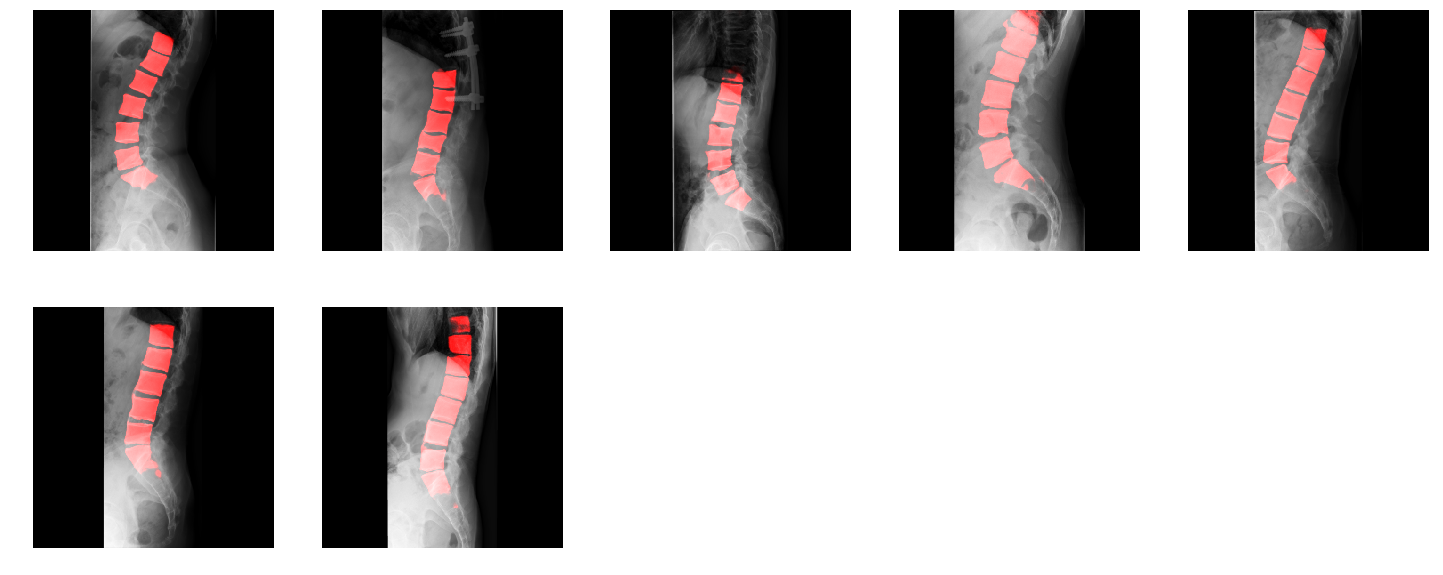

In [11]:
model=load_model('1130-unet-2nd.h5',custom_objects={'mean_iou':mean_iou})
imshow2(overlay(images_val,model.predict(images_val)))

## third trial

In [12]:
# # Build U-Net model
# inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
# s=inputs
# #s = Lambda(lambda x: x / 255) (inputs)

# c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
# c1 = Dropout(0.1) (c1)
# c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
# p1 = MaxPooling2D((2, 2)) (c1)

# c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
# c2 = Dropout(0.1) (c2)
# c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
# p2 = MaxPooling2D((2, 2)) (c2)

# c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
# c3 = Dropout(0.2) (c3)
# c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
# p3 = MaxPooling2D((2, 2)) (c3)

# c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
# c4 = Dropout(0.2) (c4)
# c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
# p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# c4m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
# c4m = Dropout(0.2) (c4m)
# c4m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4m)
# p4m = MaxPooling2D(pool_size=(2, 2)) (c4m)

# c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
# c5 = Dropout(0.3) (c5)
# c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
# c5 = Dropout(0.3) (c5)
# c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
# c5 = Dropout(0.3) (c5)
# c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

# u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
# u6 = concatenate([u6, c4m])
# c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
# c6 = Dropout(0.2) (c6)
# c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

# u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
# u6 = concatenate([u6, c4])
# c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
# c6 = Dropout(0.2) (c6)
# c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

# u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
# u7 = concatenate([u7, c3])
# c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
# c7 = Dropout(0.2) (c7)
# c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

# u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
# u8 = concatenate([u8, c2])
# c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
# c8 = Dropout(0.1) (c8)
# c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

# u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
# u9 = concatenate([u9, c1], axis=3)
# c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
# c9 = Dropout(0.1) (c9)
# c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

# model = Model(inputs=[inputs], outputs=[outputs])

# model=multi_gpu_model(model,gpus=2)

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
# model.summary()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 64, 64, 128), (None, 32, 32, 256)]

In [ ]:
# checkpointer = ModelCheckpoint('1130-unet-3rd.h5',
#                                monitor='mean_iou',
#                                mode='max',
#                                verbose=1,
#                                save_best_only=True)

# results=model.fit_generator(train_generator,
#                             validation_data=val_generator,
#                             validation_steps=1,
#                             steps_per_epoch=100,
#                             epochs=100,
#                             callbacks=[checkpointer])